Our first attempt at estimating housing prices used some naive assumptions and little data scrubbing.
As a result, our fit had a lot of bias (underfit).
We'll try to remedy that first by doing a better job of refining the data.

First we'll make necessary imports and grab the data.

In [208]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest

import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from IPython.display import clear_output

TrainingSet = pd.read_csv('data/train.csv')
TestSet = pd.read_csv('data/test.csv')

#Drop the ID columns after saving them
TrainingSetID = TrainingSet['Id']
TestSetID = TestSet['Id']
TrainingSet.drop('Id', axis = 1, inplace = True)
TestSet.drop('Id', axis = 1, inplace = True)
print("Training Set Shape: {} ".format(TrainingSet.shape))
print("Test Set Shape:     {} ".format(TestSet.shape))

Training Set Shape: (1460, 80) 
Test Set Shape:     (1459, 79) 


After removing the ID we see that our Training set has 1460 examples with 80 parameters.  The test set has 1 less parameter as it doesn't have the house price listed.

Let's try to improve the data that we have.  One thing we can do is try to remove outliers that are likely to hurt our model's accuracy.  The notes on the data specify that several houses over 4000 sq ft in size have outlier sale price values.  We'll plot these values and remove the data points > 4000 sq ft as suggested in the data notes.

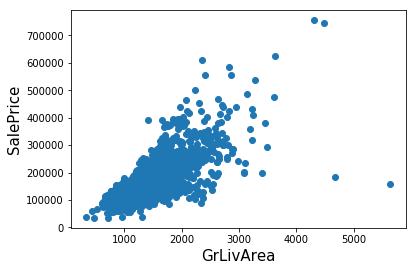

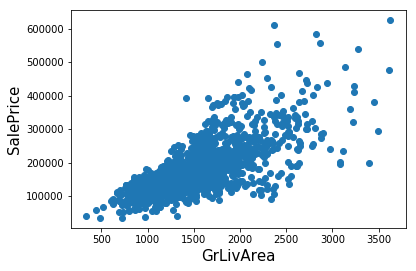

(1456, 80)


In [209]:
fig, ax = plt.subplots()
ax.scatter(x = TrainingSet['GrLivArea'], y = TrainingSet['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

TrainingSet = TrainingSet.drop(TrainingSet[(TrainingSet['GrLivArea']>4000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(TrainingSet['GrLivArea'], TrainingSet['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()
print(TrainingSet.shape)

So we removed 4 outliers from the data set.  While discarding data in a scientific setting is generally inappropriate, it is likely to improve our ability to estimate housing prices.

On our previous attempt we transformed our Y values (sale prices) logarithmically to obtain a distribution that was less skewed and adhered more to a normal curve.  We'll do that again here.

In [210]:
print("Skewness: %f" % TrainingSet['SalePrice'].skew())
print("Kurtosis: %f" % TrainingSet['SalePrice'].kurt())

#The numpy log1p function applies log(1+x) to all elements of the column
TrainingSet["SalePrice"] = np.log1p(TrainingSet["SalePrice"])

print("Skewness: %f" % TrainingSet['SalePrice'].skew())
print("Kurtosis: %f" % TrainingSet['SalePrice'].kurt())

Skewness: 1.565959
Kurtosis: 3.885283
Skewness: 0.065460
Kurtosis: 0.666423


As we can see, the skewness greatly improves after we logarithmically transform the SalePrice data.

Now that we've worked with the SalePrice data, we can combine our Training and Test sets to get a larger aggregate of potential home features.

In [211]:
n_TrainingSet = TrainingSet.shape[0] #Number of Training Set examples
n_TestSet = TestSet.shape[0] #Number of Test Set examples
Y = TrainingSet.SalePrice.values #Create independent Y data with SalePrice values
AllData = pd.concat((TrainingSet, TestSet), sort=True).reset_index(drop=True) #Combine the two sets
AllData.drop(['SalePrice'], axis=1, inplace=True) #Drop the Y data from our combined sets (since it'll be missing from half)
AllData.shape

(2915, 79)

Now we should check if any of our 79 features are missing values.

In [212]:
TotalMissing = AllData.isnull().sum().sort_values(ascending=False)
PercentMissing = (AllData.isnull().sum()/AllData.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([TotalMissing, PercentMissing], axis=1, keys=['All: Total Missing', 'All: Percent Missing'])
missing_data.head(35)

,All: Total Missing,All: Percent Missing
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageCond,159,0.054545


Some of these parameters seem like they will not be useful for assessing home value with so many missing parameters. With the limited data available, utilizing these features may lead to overfitting. Additionally, some seem likely to overlap one another (such as the many Garage qualities).  And finally, some features seem unlikely to truly impact a house's value (do people pay extra for Alley access?), though admittedly this is a bit arbitrary on my part.  We'll delete some of these columns while filling in the missing values in others.

In [213]:
#These features are missing so much data they are unlikely to be useful
AllData.drop('PoolQC', axis = 1, inplace = True)
AllData.drop('MiscFeature', axis = 1, inplace = True)
AllData.drop('Alley', axis = 1, inplace = True)

#These features overlap/correlate heavily with other features, and thus are not necessary
AllData.drop('GarageYrBlt', axis = 1, inplace = True) #Overlaps with the year the house was built
AllData.drop('GarageArea', axis = 1, inplace = True) #Overlaps with GarageCars, but less well correlated with SalePrice

#These features are so uniform across the data set that they're unlikely to help
AllData.drop('Utilities', axis = 1, inplace = True)

#These features, when missing data, indicate that the house actually lacks this feature
for col in ('Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    AllData[col] = AllData[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
    AllData[col] = AllData[col].fillna('None')
    
#These features, when missing data, indicate the numerical value should actually be 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'GarageCars'):
    AllData[col] = AllData[col].fillna(0)

#LotFrontage seems like an important value.  Though we can't know what the house's value should be,
#we can estimate it by using the median value of other houses present in the neighborhood
AllData["LotFrontage"] = AllData.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

#For MSZoning the most common value by far is 'RL', so we'll guess that's the value present for the missing data points
AllData['MSZoning'] = AllData['MSZoning'].fillna(AllData['MSZoning'].mode()[0])

#Foor 'Functional', the data description says that a missing value means it's type 'Typ'
AllData['Functional'] = AllData['Functional'].fillna('Typ')

#For 'Electrical' we only have one missing value.  The usual value is 'SBrkr' so we'll use that to fill it in
AllData['Electrical'] = AllData['Electrical'].fillna(AllData['Electrical'].mode()[0])

#For 'KitchenQual' we only have one missing value.  The usual value is the most common, 'TA'
AllData['KitchenQual'] = AllData['KitchenQual'].fillna(AllData['KitchenQual'].mode()[0])

#Exterior1st and Exterior2nd are both missing a single value, so we'll fill them with the most common option
AllData['Exterior1st'] = AllData['Exterior1st'].fillna(AllData['Exterior1st'].mode()[0])
AllData['Exterior2nd'] = AllData['Exterior2nd'].fillna(AllData['Exterior2nd'].mode()[0])

#SaleType is also missing just a single value, so we'll put in the most common option
AllData['SaleType'] = AllData['SaleType'].fillna(AllData['SaleType'].mode()[0])

#MSSubClass is also missing just a single value.  We'll input 'None' to indicate the building probably has no subclass
AllData['MSSubClass'] = AllData['MSSubClass'].fillna('None')

#Same code to check for missing values as before
TotalMissing = AllData.isnull().sum().sort_values(ascending=False)
PercentMissing = (AllData.isnull().sum()/AllData.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([TotalMissing, PercentMissing], axis=1, keys=['All: Total Missing', 'All: Percent Missing'])
missing_data.head(5)

#OPTIONAL: Dropping data categories that have few data points and seems to lead to anomalous results
#AllData.drop('3SsnPorch', axis = 1, inplace = True) 
#AllData.drop('BsmtFinSF2', axis = 1, inplace = True) 
#AllData.drop('EnclosedPorch', axis = 1, inplace = True)
#AllData.drop('ScreenPorch', axis = 1, inplace = True)
#AllData.drop('MiscVal', axis = 1, inplace = True)

,All: Total Missing,All: Percent Missing
YrSold,0,0.0
GrLivArea,0,0.0
EnclosedPorch,0,0.0
ExterCond,0,0.0
ExterQual,0,0.0


We can see that we now have no missing values in our data set, which should make analysis much easier.

A few more changes to make:  Some numerical features are actually categories (such as month/year sold), so we should transform these into strings.

We'll also add another feature, the sum of the floorspace on all 3 floors (basement + 1st floor + 2nd floor).  Total sq ft available in a house is a typical selling point and an important feature in real estate.

In [214]:
AllData['YrSold'] = AllData['YrSold'].astype(str)
AllData['MoSold'] = AllData['MoSold'].astype(str)
AllData['MSSubClass'] = AllData['MSSubClass'].apply(str)

#AllData['TotalSF'] = AllData['TotalBsmtSF'] + AllData['1stFlrSF'] + AllData['2ndFlrSF']

Some of the data, though listed as categories, are really rankings (in a way) that can be viewed numerically.  'FireplaceQu', for example (the quality of the fireplace) is given values such as 'Ex' for excellent, 'Gd' for good, and so on.  These can really be numerical rankings which will be easier for the learning algorithm to digest.  We'll transform these values.

In [215]:
EncodeCols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for i in EncodeCols:
    le = LabelEncoder() 
    le.fit(list(AllData[i].values)) 
    AllData[i] = le.transform(list(AllData[i].values))

# shape        
print('Shape all_data: {}'.format(AllData.shape))

Shape all_data: (2915, 73)


We'll finish transforming the data into numerical values by replacing remaining 'category' values with representative dummy values.

Additionally, we can feature scale. Having some numbers much larger than others (1stFlrSF is on the scale of ~1000, while # of bedrooms is on the scale of ~1) will drastically slow the learning algorithm.  We can use sklearn's RobustScaler to scale the data for us appropriately (it also accounts for highly skewed data).

In [216]:
AllData = pd.get_dummies(AllData)
AllDataColumns = list(AllData.columns.values)

scaler = RobustScaler().fit(AllData)
AllData = scaler.transform(AllData)
AllData = pd.DataFrame(AllData, columns=AllDataColumns)
print(AllData.shape)

#Write our data in case we want to check it later
Writer = pd.ExcelWriter('AllData.xlsx')
AllData.to_excel(Writer,'Sheet1')

AllData.head()

(2915, 210)


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-0.445320,1.213930,0.0,0.0,0.0,0.0,0.461749,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.354680,0.000000,0.0,0.0,0.0,-2.0,0.833333,0.0,-0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.319212,1.230988,0.0,0.0,0.0,-1.0,0.161202,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.238424,1.074627,0.0,0.0,-3.0,0.0,-0.207650,0.0,-0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.124138,1.496802,0.0,1.0,0.0,-3.0,0.392077,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


OPTIONAL:  We can try using sklearn to mass-remove outliers that exist in categories outside of simply SalePrice vs GrLivArea.  We can use IsolationForest which ‘isolates’ observations.  "IsolationForest randomly selects a feature and then randomly selects a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.  This path length, averaged over a forest of such random trees, is a measure of normality and our decision function."

Note:  Implementing this increased the overall score by ~.02 and removed some crazy outlier predictions, so it should probably stay in.

In [217]:
#OPTIONAL:  Remove additional anomalies from training set
TrainingSet = AllData[:n_TrainingSet]
TestSet = TestSet = AllData[n_TrainingSet:]
TrainingSetNumbers = TrainingSet.select_dtypes(exclude=['object']) #only look at outliers in numeric characteristics

clf = IsolationForest(max_samples = 100)
clf.fit(TrainingSetNumbers)
Y_NoAnomalies = clf.predict(TrainingSetNumbers) #Predict whether each row is an outlier [1 = good, -1 = outlier]
#print(Y_NoAnomalies) #outputs a list of 1's or 0's for each row

#Remove anomalous rows from the training set
Y_NoAnomalies = pd.DataFrame(Y_NoAnomalies, columns = ['Top'])
Y_NoAnomalies[Y_NoAnomalies['Top'] == 1].index.values

TrainingSet = TrainingSet.iloc[Y_NoAnomalies[Y_NoAnomalies['Top'] == 1].index.values]
TrainingSet.reset_index(drop = True, inplace = True)

#List number of anomalies found, as well as remaining non-anomalous rows
print("Number of Outliers:", Y_NoAnomalies[Y_NoAnomalies['Top'] == -1].shape[0])
print("Number of rows without outliers:", TrainingSet.shape[0])

#Change our Y, since we just threw out a lot of rows it contained SalePrice values for
Y = np.multiply(Y,Y_NoAnomalies.Top.values)
Y = Y[Y >= 0]

#Verify that Y has same number of entries as our new TrainingSet
print(np.prod(Y.shape))

#Reset our training set size and our dataframe housing all data
n_TrainingSet = TrainingSet.shape[0]
AllData = pd.concat([TrainingSet, TestSet])

Number of Outliers: 146
Number of rows without outliers: 1310
1310


Now we can reacquire our Training and Test sets for use in our algorithm.

In [218]:
print(AllData.shape)

TrainingSet = AllData[:n_TrainingSet]
TestSet = AllData[n_TrainingSet:]

print(TrainingSet.shape)
print(TestSet.shape)

(2769, 210)
(1310, 210)
(1459, 210)


Here I borrow a function to plot the loss and val_loss as a function of epoch, live, as the neural network progresses.  The code source is linked here: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [219]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.ylim(0, 1) 
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Now we begin creating our deep neural network model.  I separate the training set into a training set and a validation set to measure our progress as the neural network learns.  To prevent overfitting I implement dropout on 2 of the neural network layers.  Traditional relu activation functions are used.  Literature shows that the 'adam' optimizer generally is the best performing of the options available.

In [220]:
X_tr, X_val, y_tr, y_val = train_test_split(TrainingSet, Y, test_size = 0.33)
model = Sequential()
BatchNormalization()
#Removed dropout from input layer, it lead to the training set error being much lower than the validation set error
model.add(keras.layers.Dropout(0.2, input_shape=(len(TrainingSet.columns),))) #How to add dropout to input layer
model.add(Dense(1028,activation='relu')) #Input dimensions equal to # of columns in dataframe X
#model.add(Dense(1028, input_dim = len(TrainingSet.columns), activation='relu')) #Use this for no dropout on input
BatchNormalization()
Dropout(0.4) #Tried dropout of 0.5, but it gave worse results
model.add(Dense(1028,activation='relu')) #Input dimensions automatically accounted for in later layers
BatchNormalization()
Dropout(0.4)
#model.add(Dense(1028,activation='relu')) #Adding this extra input layer caused model to way underpredict house prices
#BatchNormalization()
#Dropout(0.2)
model.add(Dense(100,activation='relu'))
BatchNormalization()
Dropout(0.2)
model.add(Dense(50))
BatchNormalization()
Dropout(0.1)
model.add(Dense(1))
keras.optimizers.Adam(lr=0.00001) #Adjust the learning rate, default value of 0.001 was too large, causing wild fluctuations in loss values
model.compile(optimizer='Adam',loss='mse',metrics=['accuracy']) #metrics = ['mean_squared_error']
#model.compile(optimizer='Adam',loss='mse') #removing/changing metric had no real effect

#Also we want to save the best parameters that we obtain during the training:
BestWeightsPath = './best_weights.hdf5'
SaveBestModel = keras.callbacks.ModelCheckpoint(BestWeightsPath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Now we can use our defined model to attempt to fit the data.

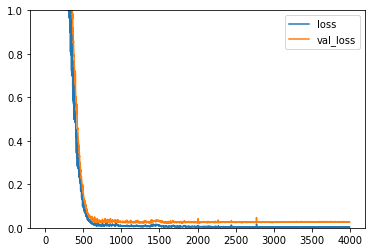


Epoch 04000: val_loss did not improve from 0.02231


In [221]:
model.fit(X_tr,y_tr,validation_data=(X_val,y_val), epochs=1000, batch_size=100, verbose=1, callbacks=[plot_losses, SaveBestModel])

Finally we can use our model to fill out the predictions for our test set and write them onto the file 'KerasSub'.  We also remember to undo the logarithmic change to the Sale Price values we implemented earlier.

In [222]:
model.load_weights(BestWeightsPath)
np.sqrt(model.evaluate(X_val,y_val))
preds = model.predict(np.array(TestSet))
subm = pd.read_csv("data/sample_submission.csv")
subm.iloc[:,1] = np.array(model.predict(np.array(TestSet)))
subm['SalePrice'] = np.expm1(subm[['SalePrice']]) #undo the logarithm transformation we did on y earlier
subm.to_csv('Keras_Sub.csv', index=None)

433/433 [==============================] - 0s 131us/step


163000.0


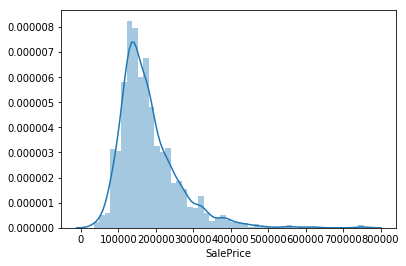

In [223]:
#Check training set price distributions vs our predictions on the test set
OriginalData = pd.read_csv('data/train.csv')
sns.distplot(OriginalData['SalePrice'])
print(OriginalData['SalePrice'].median())

153283.95816928288


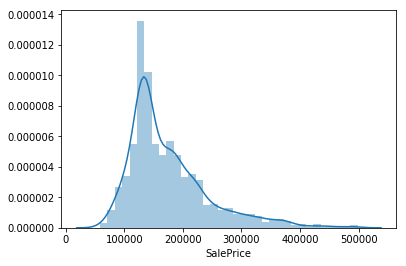

In [224]:
Results = pd.read_csv('Keras_Sub.csv')
sns.distplot(Results['SalePrice'], hist='norm')
print(Results['SalePrice'].median())